In [1]:
import os
import sys
sys.argv=['']
del sys
import argparse
from datetime import datetime
from models_architecture import *
from matplotlib.pyplot import hist
import matplotlib.pyplot as plt
from config import TRAIN_DATA_LOC, TRAIN_LABELS_LOC, TEST_DATA_LOC, TEST_LABELS_LOC, SPLIT_TRAIN, BATCH_SIZE, RUN_DIR, EMBBEDINGS_NUMBER, MODELS_NUMBER, \
                   TRAIN_DS_IND, VALID_DS_IND, TEST_DS_IND, EPOCHS, MODELS_SAVE_PATH, MIN_LOSS_SAVE, EARLY_STOP_DIFF, EMBBEDINGS_REDUCED, LINEAR_INIT, BILINEAR_INIT
from helper import select_train_valid, one_epoch_run, create_dataloaders, get_optimizer, parse_arguments, initialize_weights 
BASE_MODELS_PATH='/home/orlev/work/Face-Recognition-Of-Masked-Faces/scripts/converted_data/models'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser = argparse.ArgumentParser(description='do verification') 
parser.add_argument('-cn', '--combination-number', type=int, default=1)
args = parser.parse_args()

In [3]:
data = torch.load(TRAIN_DATA_LOC)
labels = torch.load(TRAIN_LABELS_LOC)
test_data = torch.load(TEST_DATA_LOC)[:,:,:]
test_labels = torch.load(TEST_LABELS_LOC)
mask = select_train_valid(data, SPLIT_TRAIN, args)

train_data = data[:, np.repeat(mask, 2), :]
train_labels = labels[:len(mask)][mask]
valid_data = data[:, ~np.repeat(mask, 2), :]
valid_labels = labels[:len(mask)][~mask]

In [4]:
MODEL_PATH = os.path.join(BASE_MODELS_PATH, 'NeuralNetwork5_1_32_D14_02_2022_T21_33_01_847938.pt')
model = NeuralNetwork5()
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval()

NeuralNetwork5(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (reduction1): Linear(in_features=512, out_features=32, bias=True)
  (reduction2): Linear(in_features=512, out_features=32, bias=True)
  (reduction3): Linear(in_features=512, out_features=32, bias=True)
  (reduction4): Linear(in_features=512, out_features=32, bias=True)
  (reduction5): Linear(in_features=512, out_features=32, bias=True)
  (reduction6): Linear(in_features=512, out_features=32, bias=True)
  (reduction7): Linear(in_features=512, out_features=32, bias=True)
  (fc1): Linear(in_features=672, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

In [55]:
def plotit(data, labels):
    emb1 = torch.Tensor(data[:,0::2,:]).to(device).transpose(0,1)
    emb2 = torch.Tensor(data[:,1::2,:]).to(device).transpose(0,1)
    predicted_labels = model(emb1,emb2)
    print('same/different pairs ratio: ',sum(labels)/len(labels))
    plabels = predicted_labels.cpu().detach().numpy()
    converted_labels = labels.astype(float)[:, None]
    converted_labels[converted_labels == 0] = -1
    acc = (sum((converted_labels * plabels) > 0) / len(converted_labels))[0]
    print('Accuracy: ', acc)
    
    plt.figure(figsize=(8,6))
    thresholds = np.arange(min(plabels), max(plabels), 0.01)
    train_same_person = list(np.concatenate( plabels[labels], axis=0))
    train_diff_person = list(np.concatenate( plabels[~labels], axis=0))
    _ = hist([train_same_person, train_diff_person], bins=thresholds, color=['green', 'red'], label=['same','diff'])
    plt.axvline(0,color ='black')
    plt.legend(['diff', 'same'])



same/different pairs ratio:  0.5014772727272727
Accuracy:  0.885275974025974


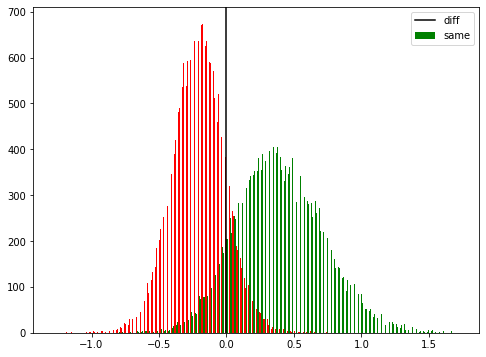

In [57]:
plotit(train_data, train_labels)

same/different pairs ratio:  0.4940909090909091
Accuracy:  0.8701298701298701


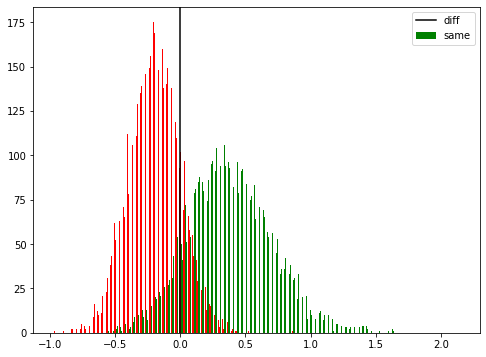

In [60]:
plotit(valid_data, valid_labels)

same/different pairs ratio:  0.5
Accuracy:  0.7700476190476191


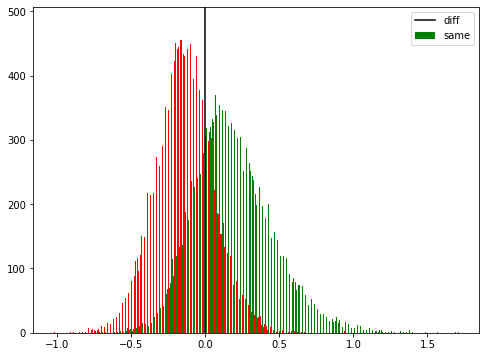

In [59]:
plotit(test_data, test_labels)